In [26]:
import featuretools as ft 
import matplotlib
import numpy as np
import utils
from utils import load_nyc_taxi_data, compute_features, preview, feature_importances
from featuretools.primitives import (Count, Day, Hour, Max, Mean, Median, Min,Minute, Month, Std, Sum, Week, Weekday,IsWeekend)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')


In [27]:
%matplotlib inline

In [28]:
##Download and load the raw data as pandas dataframes
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data() 
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,514030,2,2016-04-02 00:00:00,2016-04-02 00:17:00,1,2.46,-73.987595,40.754711,-73.959633,40.762836,1,1039,AA,K
1,514031,1,2016-04-02 00:00:00,2016-04-02 00:24:00,2,7.90,-73.924713,40.745567,-73.972763,40.793354,1,1454,L,U
2,514032,1,2016-04-02 00:00:00,2016-04-02 00:19:00,1,1.00,-73.989800,40.732994,-74.000557,40.742622,1,1168,H,Q
3,514033,2,2016-04-02 00:00:00,2016-04-02 00:01:00,1,0.02,-73.987465,40.719822,-73.987289,40.720016,2,35,AC,AC
4,514034,1,2016-04-02 00:01:00,2016-04-02 00:58:00,2,19.00,-73.790131,40.643429,-73.975594,40.779327,1,3470,G,I
5,514035,1,2016-04-02 00:01:00,2016-04-02 00:09:00,2,1.50,-73.981956,40.765518,-73.968124,40.753407,1,458,AR,N
6,514036,1,2016-04-02 00:01:00,2016-04-02 00:05:00,1,1.50,-73.980019,40.780594,-73.968132,40.799595,2,213,AV,U
7,514037,1,2016-04-02 00:01:00,2016-04-02 00:20:00,1,4.20,-73.990501,40.756561,-73.986008,40.719414,2,1142,AA,AC
8,514038,1,2016-04-02 00:01:00,2016-04-02 00:10:00,1,0.60,-73.986198,40.730492,-73.991798,40.722240,1,501,AT,AC
9,514039,1,2016-04-02 00:01:00,2016-04-02 00:17:00,1,0.60,-73.990959,40.734890,-74.001816,40.739319,1,954,R,Q


3573
2
746.0989


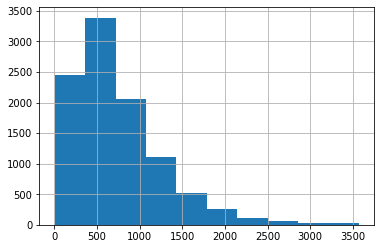

In [29]:
##We can also plot some aspects of the data to get a better sense of its distributions. For instance, here is the trip_duration variable. 
trips.trip_duration.hist() 
print(trips.trip_duration.max()) 
print(trips.trip_duration.min()) 
print(trips.trip_duration.mean())

In [30]:
trips.shape[0] # tells us how many trips are in the dataset

10000

In [ ]:
'''
Lets create entities and relationships. The three entities in this data are

*trips
*pickup_neighborhoods
*dropoff_neighborhoods

This data has the following relationships

*pickup_neighborhoods --> trips (one neighboorhood can have multiple trips that start in it. This means pickup_neighborhoods is the parent_entity and trips is the child entity)
*dropoff_neighborhoods --> trips (one neighboorhood can have multiple trips that end in it. This means dropoff_neighborhoods is the parent_entity and trips is the child entity)
'''

In [32]:
entities = {
        "trips": (trips, "id", 'pickup_datetime' ),
        "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
        "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
        }

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]
 

In [ ]:
'''
In featureools, we can create transform features by specifying transform primitives. Below we specify a transform primitive called weekend and here is what it does:
*It can be applied to any datetime column in the data.
*For each entry in the column, it assess if it is a weekend and returns a boolean.

In this specific data, there are two datetime columns pickup_datetime and dropoff_datetime. The tool automatically creates features using the primitive and these two columns as shown below.
'''

In [33]:

trans_primitives = [IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [34]:
print(f"Number of features: {len(features)}") 
features

Number of features: 13


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [ ]:
feature_matrix = compute_features(features, trips[['id', 'pickup_datetime'] ])
preview(feature_matrix, 5)

In [ ]:
'''
Add Minute, Hour, Week, Month, Weekday , etc primitives
All these transform primitives apply to datetime columns
'''

In [24]:
trans_primitives = [Minute, Hour, Day, Week, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [25]:
print("Number of features: %d" % len(features))
features

Number of features: 75


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: WEEK(pickup_datetime)>,
 <Feature: WEEK(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.SUM(trips.trip_duration)>,
